Lets get started! We'll begin with installing `motionmapperpy` in our colab instance. \

# 1.&nbsp;Installing `motionmapperpy`

We'll clone the motionmapperpy repository from github to the colab instance we're working in. We can do that by running the following code cell.

In [6]:
!git clone https://kanishkbjain@github.com/uklibaite/behavior-map-tutorial

Cloning into 'behavior-map-tutorial'...
fatal: could not read Password for 'https://kanishkbjain@github.com': No such device or address


In [1]:
!git clone https://github.com/bermanlabemory/motionmapperpy

Cloning into 'motionmapperpy'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 111 (delta 52), reused 110 (delta 51), pack-reused 0
Receiving objects: 100% (111/111), 18.88 MiB | 26.99 MiB/s, done.
Resolving deltas: 100% (52/52), done.


You'll notice the `motionmapperpy` folder created in the working directory in the left pane. This is the repository we just cloned and it contains `motionmapperpy` package and some toy datasets in the data folder. Note that our current working path is **/content/**, in case you ever get lost. We still need to install motionmapperpy as a python package, and we can do that by running the command below > 

In [2]:
%cd motionmapperpy
!python setup.py install
%cd ..

/content/motionmapperpy
running install
running bdist_egg
running egg_info
creating motionmapperpy.egg-info
writing motionmapperpy.egg-info/PKG-INFO
writing dependency_links to motionmapperpy.egg-info/dependency_links.txt
writing requirements to motionmapperpy.egg-info/requires.txt
writing top-level names to motionmapperpy.egg-info/top_level.txt
writing manifest file 'motionmapperpy.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'motionmapperpy.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/motionmapperpy
copying motionmapperpy/wshed.py -> build/lib/motionmapperpy
copying motionmapperpy/setrunparameters.py -> build/lib/motionmapperpy
copying motionmapperpy/wavelet.py -> build/lib/motionmapperpy
copying motionmapperpy/__init__.py -> build/lib/motionmapperpy
copying motionmapperpy/motionmapper.py -> build/lib/motionmapperpy
copying motionmapp

Great! Now we have `motionmapperpy` installed on this colab runtime. **We'll need to restart the runtime** so that this notebook is correctly able to recognize motionmapperpy as an installed package. We can restart the instance by **going to Runtime->Restart Runtime** in the menu bar. Note that restarting the runtime does not delete files and folders we created or remove python packages installed in this colab instance. But doing **Factory Reset Runtime** will do all of those things, so be careful! Also, note that Google will kick you out if you're inactive briefly, in which case the runtime will be factory reset.


Once you restart the runtime, you are good to move on to the next section!

# 1 Exploring a toy dataset

There are three small datasets included with the motionmapper repository. These are present in **`motionmapperpy/data`** and these datasets are:

1. **Mouse dataset** : **mouse_movie.avi** contains video of a mouse and **mouse_movie_projections.mat** contains PCA projections obtained after segmentation and alignment of this movie. 

2. **Fly video dataset** : **fly_movie.avi** contains video of a fly and **fly_movie_projections.mat** contains PCA projections obtained after segmentation and alignment of this movie. 

3. **Leap tracked fly dataset** : This dataset has two movies **fly_leap_test.mp4** and **fly_leap_test_2.mp4** with 2 corresponding h5 files containing 32 points tracked using LEAP[1][2]


[1] https://www.nature.com/articles/s41592-018-0234-5


[2] https://dataspace.princeton.edu/handle/88435/dsp01pz50gz79z

**In this notebook**, we'll look at the LEAP tracked fly dataset. We'll import some packages to kick things off

In [1]:
import glob, os, pickle, sys
from datetime import datetime

import hdf5storage # this packages helps load and save .mat files older than v7

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

from sklearn.decomposition import PCA

from tqdm import tqdm 
from scipy.ndimage import median_filter
import time, copy 

from matplotlib import rc
rc('animation', html='jshtml')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2138112/45929032 bytes (4.7%)5758976/45929032 bytes (12.5%)9502720/45929032 bytes (20.7%)13197312/45929032 bytes (28.7%)16867328/45929032 bytes (36.7%)20406272/45929032 bytes (44.4%)23986176/45929032 bytes (52.2%)27090944/45929032 bytes (59.0%)30507008/45929032 bytes (66.4%)33964032/45929032 bytes (73.9%)37773312/45929032 bytes (82.2%)41533440/45929032 bytes (90.4%)

Now we can load the files associated with this dataset. We'll read the two video files using `moviepy`, and the two .h5 tracking datasets using pandas. 

In [2]:
clips = [VideoFileClip('/content/motionmapperpy/data/fly_leap_test.mp4'), 
         VideoFileClip('/content/motionmapperpy/data/fly_leap_test_2.mp4')]

h5s = [pd.read_hdf('motionmapperpy/data/fly_leap_test_positions.h5'), 
       pd.read_hdf('motionmapperpy/data/fly_leap_test_2_positions.h5')]

Let's first explore some properties of the loaded movie clips and tracking data.

In [3]:
for i,m in enumerate(clips):
  print('Clip %i is %i seconds long at %i fps. '
  'The frames are %i px wide and %i px high.'%(i+1, m.duration, m.fps, m.w, m.h))
print()
for i,h5 in enumerate(h5s):
  print('.h5 file %i has shape %s.'%(i, h5.shape))

Clip 1 is 200 seconds long at 100 fps. The frames are 192 px wide and 192 px high.
Clip 2 is 200 seconds long at 100 fps. The frames are 192 px wide and 192 px high.

.h5 file 0 has shape (20000, 96).
.h5 file 1 has shape (20000, 96).


We can also use handy pandas functions to look at the first few rows of the tracking dataset >

In [4]:
h5s[0].head()

scorer     LEAP                                                          \
bodyparts  head                    eyeL                     eyeR          
coords        x      y likelihood     x      y likelihood      x      y   
0          94.0  148.0   0.997976  78.0  135.0   0.936517  111.0  136.0   
1          95.0  147.0   0.966769  78.0  135.0   0.952672  111.0  135.0   
2          95.0  147.0   0.983893  78.0  135.0   0.944753  111.0  135.0   
3          95.0  147.0   0.975566  77.0  135.0   0.935152  111.0  135.0   
4          94.0  148.0   0.983482  77.0  135.0   0.934642  111.0  135.0   

scorer                      ...                                              \
bodyparts             neck  ...  hindlegL3 hindlegL4                  wingL   
coords    likelihood     x  ... likelihood         x     y likelihood     x   
0           1.011603  95.0  ...   0.658106      81.0  45.0   0.378380  89.0   
1           0.985119  95.0  ...   0.583825      81.0  47.0   0.192607  89.0   
2           0.994426  95.0  ...   0.571004      81.0  47.0   0.285333  89.0   
3           0.991430  95.0  ...   0.519479      85.0  46.0   0.236658  89.0   
4           0.983904  95.0  ...   0.606728      81.0  46.0   0.399705  89.0   

scorer                                              
bodyparts                   wingR                   
coords        y likelihood      x     y likelihood  
0          16.0   0.992454  102.0  17.0   0.914016  
1          16.0   0.990767  101.0  17.0   0.895895  
2          16.0   1.003834  101.0  17.0   0.971727  
3          16.0   0.973690  101.0  17.0   0.969307  
4          16.0   0.980679  101.0  17.0   0.983998  

[5 rows x 96 columns]

*So* it seems like the .h5 files have 32 bodyparts tracked, and there are 3 columns for each of the tracked bodyparts. They contain the `x` and `y` positions, as well as the `likelihood` value of the tracked position of each part. 

We'll ditch pandas now and convert these datasets to numpy arrays, and let's also remove all the likelihood columns in these as well.

In [5]:
# We're removing every 3rd column since that contains the likelihood values
h5s = [h5.values[:,np.mod(np.arange(1,h5.shape[1]+1),3)!=0] for h5 in h5s]

To remove erratic tracking errors, we can median filter our data. We'll do that below and also reshape the data so that it is easier to work with.

In [6]:
# Reshape the arrays so that they are easier to work with. 
h5s = [median_filter(x, size=(5,1)) for x in h5s]

h5s = [i.reshape((-1, i.shape[1]//2, 2)) for i in h5s]
print('New shapes : %s'%([i.shape for i in h5s]))

New shapes : [(20000, 32, 2), (20000, 32, 2)]


Great! Now we are ready to plot and see what our dataset looks like. Below we'll use `matplotlib` to overlay tracking data on the video files. We'll read video frames using moviepy `videofileclip` objects stored in `clips`. Running this cell may take upto **1 minute**.



100%|█████████▉| 400/401 [01:00<00:00,  6.61it/s]


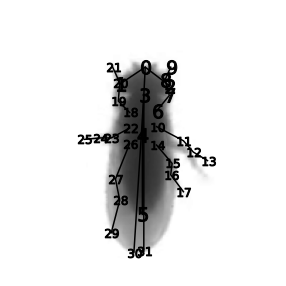

In [7]:
# This will take about a 50 seconds to run. 

fig, ax = plt.subplots(figsize=(10,5))
h5ind = 0
tstart = 7000

connections = [np.arange(6,10), np.arange(10,14), np.arange(14,18), np.arange(18,22), np.arange(22,26), np.arange(26,30),
              [2,0,1],[0,3,4,5], [31,3,30]]

try:
  tqdm._instances.clear()
except:
  pass

def animate(t):
  t = int(t*clips[h5ind].fps)+tstart
  ax.clear()
  for conn in connections:
      ax.plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], 'k-')
  for i in range(h5s[h5ind].shape[1]):
      ax.scatter(h5s[h5ind][t, i,0], h5s[h5ind][t, i,1], marker='$%i$'%i, s=200, color='k')
  ax.imshow(clips[h5ind].get_frame((t)/clips[h5ind].fps), cmap='Greys', origin='lower')
  ax.set_aspect('equal')
  ax.axis('off')

  return mplfig_to_npimage(fig)

anim = VideoClip(animate, duration=20)
anim.ipython_display(fps=20, loop=True, autoplay=True)


Working in the positions space is a little challenging with flies, since there are a lot of correlations between different tracked points. We can see this in the time series of positions below

Text(0, 0.5, 'X and Y positions (px)')

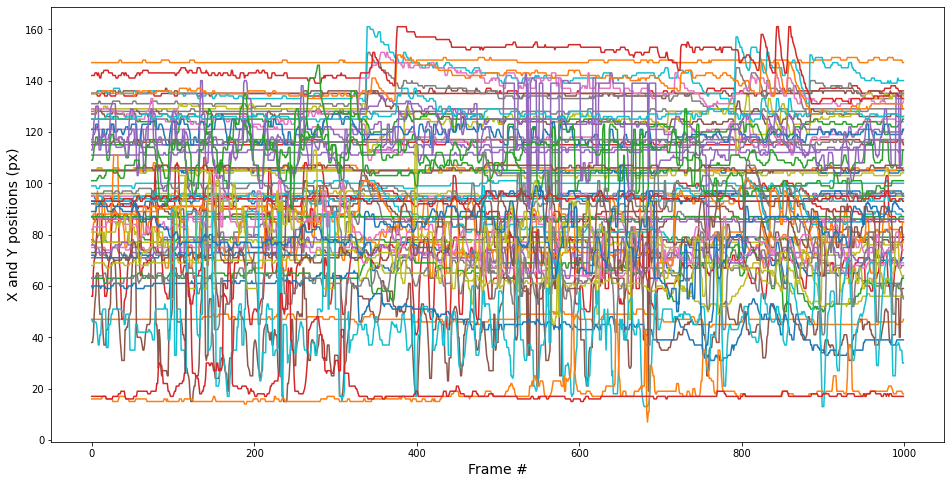

In [8]:
fig, ax = plt.subplots(figsize=(16,8))
_ = ax.plot(h5s[0][:1000,:].reshape((1000,-1)))
ax.set_xlabel("Frame #", fontsize=14)
ax.set_ylabel("X and Y positions (px)", fontsize=14)
# ax.set_ylim([-0.5,1.5])

Instead, we can compute various angles using these 32 positions. Below, we'll compute 22 new angles in each frame using these positions, such as the angle between wingtips (`(31, 0, 30)` in the above image). 

In [9]:
#convert to angles space


angleinds = [[1,0,2,0], [0,3,4,0], [3,4,5,0], [31,3,30,1], [6,7,8,0], [7,8,9,0], [10, 11, 12,0], 
          [11, 12, 13, 0], [14,15,16, 0] ,[15,16,17,0], [26,27,28,0] , [27,28,29,0], [22,23,24,0],
          [23,24,25,0], [18,19,20,0], [19,20,21,0], [3,4,18,0], [3,4,22,0], [3,4,26,0], [3,4,6,0],
          [3,4,10,0], [3,4,14,0]]

angleh5s = [np.zeros((h5.shape[0], len(angleinds))) for h5 in h5s]

def angle_between(v1, v2, small_angle=False):
    ang1 = np.arctan2(v1[:,1], v1[:,0])
    ang2 = np.arctan2(v2[:,1], v2[:,0])
    if small_angle == 1:
        out = np.rad2deg((ang1 - ang2) % (2 * np.pi))
        out[out>180] = -1*(360-out[out>180])
        return out
    else:
        return np.rad2deg((ang1 - ang2) % (2 * np.pi))


for hi,h5 in enumerate(h5s):
    for ai, aind in enumerate(angleinds):
        v1 = h5[:,aind[0]]-h5[:,aind[1]]
        v2 = h5[:,aind[2]]-h5[:,aind[1]]
        angleh5s[hi][:,ai] = angle_between(v1, v2, small_angle=aind[3])


We can look at the angles time series below. We're plotting only 5 angles here just for the sake of visualization.

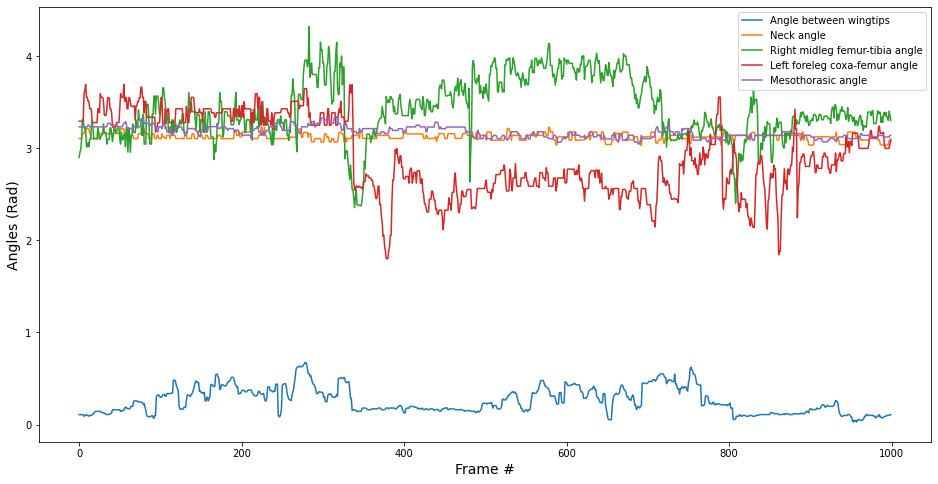

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
labels = ['Angle between wingtips', 'Neck angle', 'Right midleg femur-tibia angle', 
          'Left foreleg coxa-femur angle', 'Mesothorasic angle']
for i,l in zip([3, 1, 13, 4, 2], labels): 
  _ = ax.plot(angleh5s[0][:1000,i]* np.pi/(180), label=l)
ax.set_xlabel("Frame #", fontsize=14)
ax.set_ylabel("Angles (Rad)", fontsize=14)
ax.legend()

It seems like some of these angles vary a lot and some very little. We can get rid of this asymmetric scaling by doing a min-max scaling, where we constrain each angle to scale between 0 and 1. 

(0.0, 1.0)

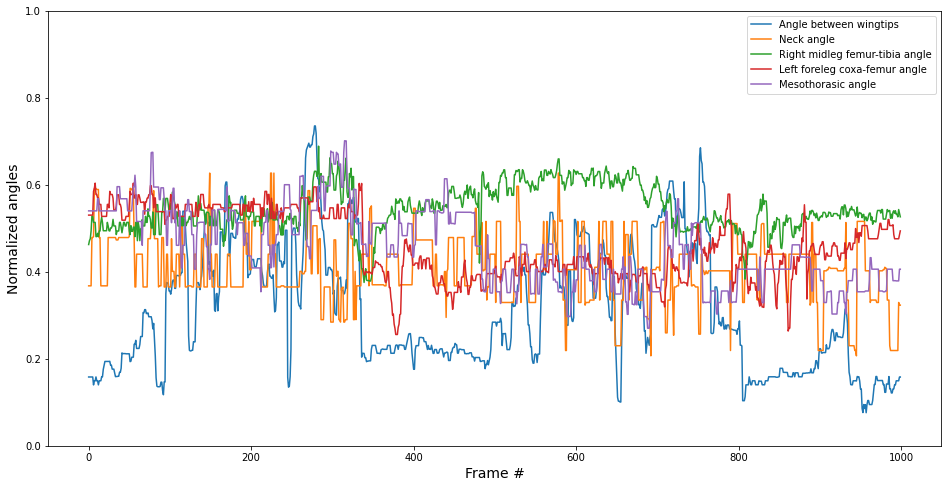

In [11]:
# let's normalize these angles so they fall bw 0 and 1

angleh5s_min = []
for ah5 in angleh5s:
    x = copy.deepcopy(ah5)
    x = x - np.min([np.min(x, 0) for x in angleh5s], 0)[None, :]
    angleh5s_min.append(x)

angleh5s_normed = []
for ah5min in angleh5s_min:
    x = copy.deepcopy(ah5min)
    x = x/np.max([np.max(x, 0) for x in angleh5s_min], 0)[None, :]
    angleh5s_normed.append(x)

fig, ax = plt.subplots(figsize=(16,8))
labels = ['Angle between wingtips', 'Neck angle', 'Right midleg femur-tibia angle', 
          'Left foreleg coxa-femur angle', 'Mesothorasic angle']
for i,l in zip([3, 1, 13, 4, 2], labels): 
  _ = ax.plot(angleh5s_normed[0][:1000,i], label=l)
ax.set_xlabel("Frame #", fontsize=14)
ax.set_ylabel("Normalized angles", fontsize=14)
ax.legend()
ax.set_ylim([0, 1.])

Now, we have a 22-dimensional feature space that is normalized, and we can use our favourite tool to reduce the dimensionality further to ease up on computational costs. Here, we'll use PCA to reduce the dimensions even further.

We're using the PCA implementatoin from [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) here.

We'll pick the first 12 components that explain 95% variance.


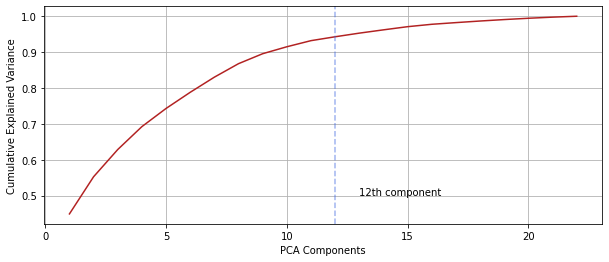

In [12]:
# Concatenate the two files for downstream analyses
x = np.concatenate(angleh5s_normed, axis=0)
# x.shape -> 40000, 22
variance_threshold = 0.95

#We are using sklearn.decomposition.PCA here
p = PCA()
y = p.fit_transform(x)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(np.arange(1, x.shape[1]+1), np.cumsum(p.explained_variance_ratio_), color='firebrick')

#This calculates the number of PCA components required to surpass teh variance threshold
comps_above_thresh = np.argwhere(np.cumsum(p.explained_variance_ratio_)>variance_threshold)[0][0]

ax.axvline(x=comps_above_thresh, color='royalblue', linestyle='--', alpha=0.5)
ax.text(x = comps_above_thresh + 1, y = 0.5, s='%ith component'%comps_above_thresh)
ax.set_xlabel('PCA Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.grid()

print('We\'ll pick the first %i components that'
' explain %i%% variance.'%(comps_above_thresh, variance_threshold*100))

We can look at the feature space composition of the leading principal components below. 

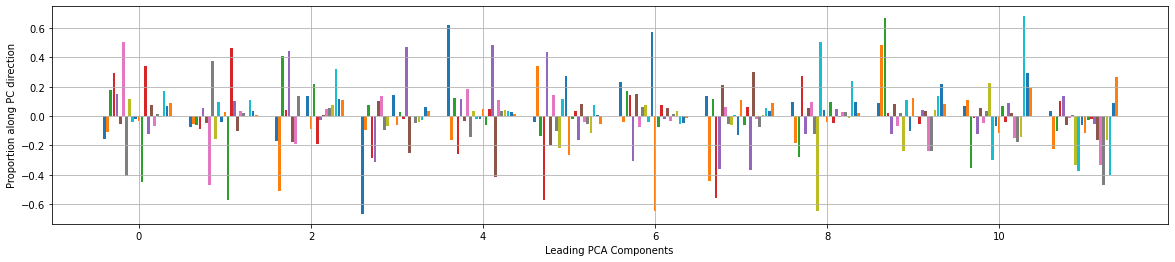

In [13]:
fig, ax = plt.subplots(figsize=(20,4))

for i in range(comps_above_thresh):
  for pi in range(x.shape[1]):
    ax.bar((i-0.4+pi*(0.8/x.shape[1])), p.components_[i, pi], width=(0.7/x.shape[1]), label='Angle %i'%i)
  ax.set_prop_cycle(None)

ax.set_xlabel('Leading PCA Components ')
ax.set_ylabel('Proportion along PC direction')
# ax.legend()
ax.grid()
plt.show()

This gives us some idea of how these maximally varying components are oriented in our high dimensional feature space.


Now we can reduce our feature space dimensions further! Note that here we use variable `y` which was obtained after the PCA transformation.

In [14]:
#picking PCA components above threshold
y = y[:,:comps_above_thresh]
print(y.shape)

#Let's also split y to the size of original h5 files.
projs_list = np.split(y, [h5s[0].shape[0]])

print([p.shape for p in projs_list])

(40000, 12)
[(20000, 12), (20000, 12)]


Now we have **projs_list**, which contains two low-dimensional time series. 

# 2 Creating a MotionMapper project directory

Now that we have two low dimensional time series which **may** not set Google servers on fire, we will create our project directory for running `motionmapperpy`. Having a project directory is awesome, as it helps us stay organized when working with big datasets and multiple files. It allows datasets to be easily referenced and loaded without exhausting memory, and we can store pipeline outputs in well-defined and structured files.


Lets start by importing `motionmapperpy` and creating a project directory.

In [15]:
import motionmapperpy as mmpy


projectPath = '/content/Fly_Leap_mmpy'

# This creates a project directory which will contains all motionmappery pipeline
# related data in one place.

mmpy.createProjectDirectory(projectPath)


Creating : /content/Fly_Leap_mmpy
Creating : /content/Fly_Leap_mmpy/Projections
Creating : /content/Fly_Leap_mmpy/TSNE_Projections
Creating : /content/Fly_Leap_mmpy/TSNE
Creating : /content/Fly_Leap_mmpy/UMAP


Now lets store the two low-d time series in **projs_list** to the *`Projections`* folder in the project directory.



In [17]:
for i,projs in enumerate(projs_list):
    hdf5storage.savemat('%s/Projections/dataset_%i_pcaModes.mat'%(projectPath, i+1), {'projections':projs})


We'll now go through `motionmapperpy` parameters. They are a handful and can be overwhelming, but they are very easy to understand! 

Parameters are cruicial to `motionmapperpy` as they lay out some hard-coded choices we need to make when running this pipeline. I will explain each parameter as we encounter them in the cell below, so please read through this cell below as you run it.


In [18]:
"""2. Setup run parameters for MotionMapper."""

#% Load the default parameters.
parameters = mmpy.setRunParameters() 

# %%%%%%% PARAMETERS TO CHANGE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# These need to be revised everytime you are working with a new dataset. #

parameters.projectPath = projectPath #% Full path to the project directory.


parameters.method = 'TSNE' #% We can choose between 'TSNE' or 'UMAP'

parameters.minF = 1        #% Minimum frequency for Morlet Wavelet Transform

parameters.maxF = 50       #% Maximum frequency for Morlet Wavelet Transform,
                           #% equal to Nyquist frequency for your measurements.

parameters.samplingFreq = 100    #% Sampling frequency (or FPS) of data.

parameters.numPeriods = 25       #% No. of dyadically spaced frequencies to
                                 #% calculate between minF and maxF.

parameters.pcaModes = comps_above_thresh #% Number of low-d features.

parameters.numProcessors = 4     #% No. of processor to use when parallel
                                 #% processing for wavelet calculation (if not using GPU)  
                                 #% and for re-embedding. -1 to use all cores.

parameters.useGPU = -1           #% GPU to use for wavelet calculation, 
                                 #% set to -1 if GPU not present

parameters.training_numPoints=3000    #% Number of points in mini-data training.


# %%%%% NO NEED TO CHANGE THESE UNLESS MEMORY ERRORS OCCUR %%%%%%%%%%

parameters.trainingSetSize=5000  #% Total number of training set points to find. 
                                 #% Increase or decrease based on
                                 #% available RAM. For reference, 36k is a 
                                 #% good number with 64GB RAM.

parameters.embedding_batchSize = 30000  #% Lower this if you get a memory error when 
                                        #% re-embedding points on a learned map.

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Above covers usually relevant parameters when running `motionmapperpy`. However, there are parameters associated with tSNE and UMAP implementations, such as below, which aren't usually required to be changed.

In [19]:
# %%%%%%% tSNE parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#% can be 'barnes_hut' or 'exact'. We'll use barnes_hut for this tutorial for speed.
parameters.tSNE_method = 'barnes_hut' 

# %2^H (H is the transition entropy)
parameters.perplexity = 32

# %number of neigbors to use when re-embedding
parameters.maxNeighbors = 200

# %local neighborhood definition in training set creation
parameters.kdNeighbors = 5

# %t-SNE training set perplexity
parameters.training_perplexity = 20


# %%%%%%%% UMAP Parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Size of local neighborhood for UMAP.
n_neighbors = 15

# Negative sample rate while training.
train_negative_sample_rate = 5

# Negative sample rate while embedding new data.
embed_negative_sample_rate = 1

# Minimum distance between neighbors.
min_dist = 0.1


# 3 Computing wavelet amplitudes

This section is not required to be run motionmapperpy, but we'll go through it to visualize spectrograms on one of the low-dimensional time series.

We'll use `mmpy.findWavelets` function to obtain the waveletes, and plot the obtained spectrogram for each feature/projection. 

	 Calculating wavelets, clock starting.
	 Using #4 CPUs.
	 Done at 1.44 seconds.


Text(0.5, 0, 'Frames')

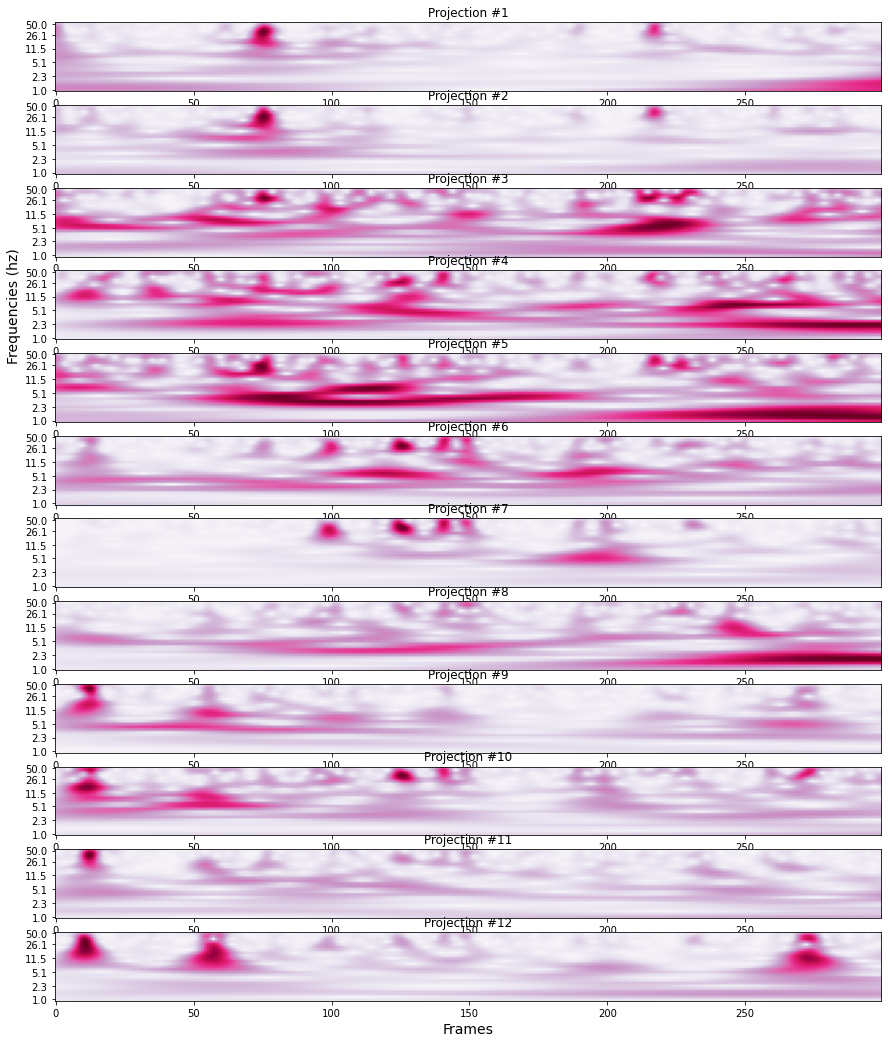

In [20]:
wlets, freqs = mmpy.findWavelets(projs_list[0], projs_list[0].shape[1], parameters.omega0, parameters.numPeriods, parameters.samplingFreq, parameters.maxF, parameters.minF, parameters.numProcessors, parameters.useGPU)

fig, axes = plt.subplots(y.shape[1], 1, figsize=(20,18))

for i, ax in enumerate(axes.flatten()):
  ax.imshow(wlets[:300,25*i:25*(i+1)].T, cmap='PuRd', origin='lower')
  ax.set_yticks([0, 5, 10, 15, 20, 24])
  ax.set_yticklabels(['%0.1f'%freqs[j] for j in [0, 5, 10, 15, 20, 24]])
  if i == 3:
    ax.set_ylabel("Frequencies (hz)", fontsize=14)
  ax.set_title('Projection #%i'%(i+1))
ax.set_xlabel('Frames', fontsize=14)


As we can see, our low-d time series is soon dwarfed by the 25-dimensional wavelet amplitudes obtained for each low-d feature! This is why we spent some time reducing the dimensionality of our original data as much as possible. 

With this insight, lets move to the next section where starts some heavy lifting for the colab instance.

# 4 Creating a training tSNE/UMAP 

Even though we are working with toy datasets, we have two extremely high dimensional time series to create a smaller and more interpretable representation. tSNE and UMAP both need to compute distances in high-dimensional space to find neighbors, and this computation can quickly exhaust available memory. 

To navigate this challenge, we do a subsampling procedure to create a training set, and use tSNE or UMAP to create a training embedding/representation. All of this is done in the cell below.

**Time taken** : TSNE 86 sec | UMAP 44 sec

In [21]:
t1 = time.time()

mmpy.subsampled_tsne_from_projections(parameters, parameters.projectPath)

print('Done in %i seconds.'%(time.time()-t1))


Finding Training Set
Finding training set contributions from data set 1/2 : 
/content/Fly_Leap_mmpy/Projections/dataset_2_pcaModes.mat
	 Loading Projections
	 Calculating Wavelets
	 Calculating wavelets, clock starting.
	 Using #4 CPUs.
	 Done at 1.21 seconds.
Finding Distances
Computing t-SNE
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.021s...
[t-SNE] Computed neighbors for 3000 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.178270
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.556137
[t-SNE] KL divergence after 1000 iterations: 1.063389
Finding Templates.
Finding training set contributions from data set 2/2 : 
/content/Fly_Leap_mmpy/Projections/dataset_1_pcaModes.mat
	 Loading Projections
	 Calculating Wavelets
	 Calculating wavelets, clo

Note that the `training set` and `training embedding` are both save in the `project_directory/TSNE` or `project_directory/UMAP`. We'll load the training embedding below and plot it. You can play around with the sigma value here to change the coarseness of the density map. 

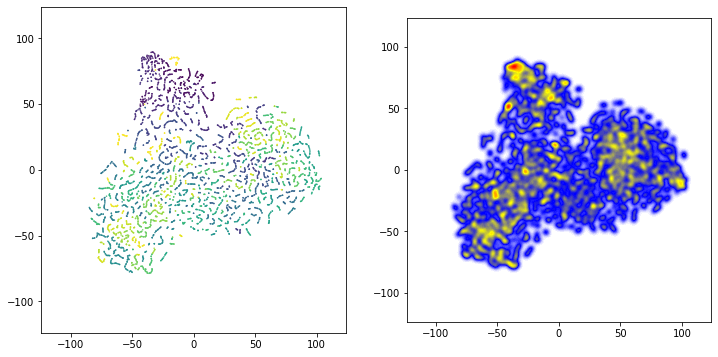

In [22]:
trainy = hdf5storage.loadmat('%s/%s/training_embedding.mat'%(parameters.projectPath, parameters.method))['trainingEmbedding']
m = np.abs(trainy).max()


sigma=2.0
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m-20, m+20])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(trainy[:,0], trainy[:,1], marker='.', c=np.arange(trainy.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

# 5 Finding embedding for all data

Now, we can find embeddings for our entire dataset! We'll use `mmpy.findEmbeddings` function which requires the training data, training embedding and the low-d 'projection' time series. We'll save the obtained embeddings for each dataset neatly in the Projections folder so that we can reference them later.

**Running time** : TSNE 19 mins | UMAP 3 mins

In [24]:
#tsne takes 19 mins
tall = time.time()

import h5py
tfolder = parameters.projectPath+'/%s/'%parameters.method

# Loading training data
with h5py.File(tfolder + 'training_data.mat', 'r') as hfile:
    trainingSetData = hfile['trainingSetData'][:].T

# Loading training embedding
with h5py.File(tfolder+ 'training_embedding.mat', 'r') as hfile:
    trainingEmbedding= hfile['trainingEmbedding'][:].T

if parameters.method == 'TSNE':
    zValstr = 'zVals' 
else:
    zValstr = 'uVals'

projectionFiles = glob.glob(parameters.projectPath+'/Projections/*pcaModes.mat')
for i in range(len(projectionFiles)):
    print('Finding Embeddings')
    t1 = time.time()
    print('%i/%i : %s'%(i+1,len(projectionFiles), projectionFiles[i]))


    # Skip if embeddings already found.
    if os.path.exists(projectionFiles[i][:-4] +'_%s.mat'%(zValstr)):
        print('Already done. Skipping.\n')
        continue

    # load projections for a dataset
    projections = hdf5storage.loadmat(projectionFiles[i])['projections']

    # Find Embeddings
    zValues, outputStatistics = mmpy.findEmbeddings(projections,trainingSetData,trainingEmbedding,parameters)

    # Save embeddings
    hdf5storage.write(data = {'zValues':zValues}, path = '/', truncate_existing = True,
                    filename = projectionFiles[i][:-4]+'_%s.mat'%(zValstr), store_python_metadata = False,
                      matlab_compatible = True)
    
    # Save output statistics
    with open(projectionFiles[i][:-4] + '_%s_outputStatistics.pkl'%(zValstr), 'wb') as hfile:
        pickle.dump(outputStatistics, hfile)

    del zValues,projections,outputStatistics

print('All Embeddings Saved in %i seconds!'%(time.time()-tall))


Finding Embeddings
1/2 : /content/Fly_Leap_mmpy/Projections/dataset_2_pcaModes.mat
Finding Wavelets
	 Calculating wavelets, clock starting.
	 Using #4 CPUs.
	 Done at 1.71 seconds.
Finding Embeddings
	 Processing batch #   1 out of    1
	 Calculating distances for batch    1
	 Calculated distances for batch    1 5.03seconds.
	 Calculating fminProjections for batch    1


Process ForkPoolWorker-18:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-17:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
Process ForkPoolWorker-19:
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_byte

KeyboardInterrupt: ignored

We can visualize the obtained embeddings by calling the cell below.

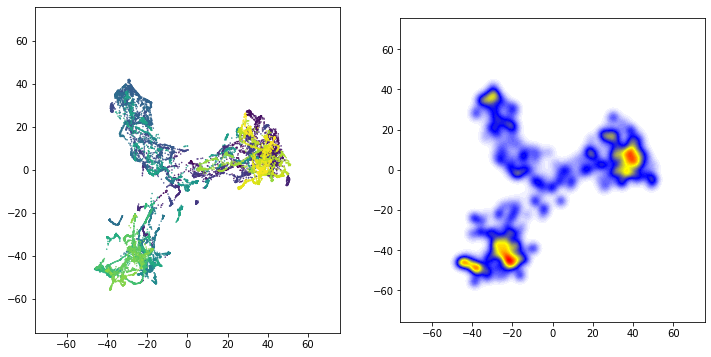

In [24]:
# load all the embeddings
for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
  ally = hdf5storage.loadmat(i)['zValues']

m = np.abs(ally).max()

sigma=2.0
_, xx, density = mmpy.findPointDensity(ally, sigma, 511, [-m-20, m+20])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(ally[:,0], ally[:,1], marker='.', c=np.arange(ally.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

There is another handy function in `motionmapperpy` called `mmpy.findWatershedRegions`. This will create an iterative watershed transform until the given `minimum_regions` are found in the density map.

It saves watershed transformed output of the embedding in `project_director/UMAP/zVals_wShed_groups.mat` file.


1/2 Loading embedding for dataset_1_pcaModes 0.00 seconds.
2/2 Loading embedding for dataset_2_pcaModes 0.02 seconds.
Starting watershed transform...
	 Sigma 2.25, Regions 24
	 Sigma 2.30, Regions 24
	 Sigma 2.35, Regions 23
	 Sigma 2.40, Regions 22
	 Sigma 2.45, Regions 21
	 Sigma 2.50, Regions 20
Assigning watershed regions...
	 tempsave done.
All data saved in UMAP/zVals_wShed_groups.mat.


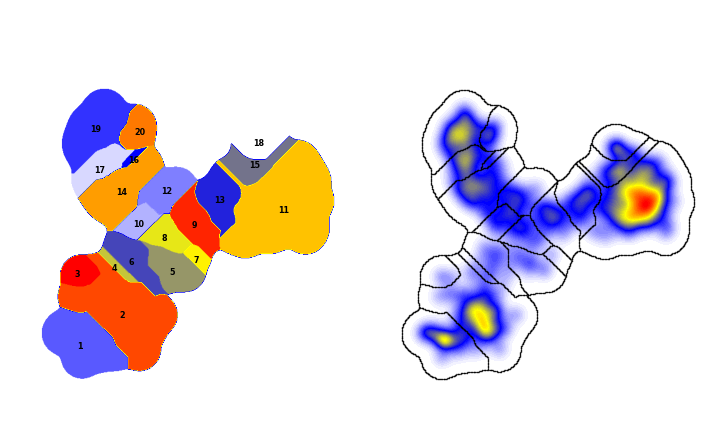

In [25]:

startsigma = 4.2 if parameters.method == 'TSNE' else 2.2
mmpy.findWatershedRegions(parameters, minimum_regions=20, startsigma=startsigma, pThreshold=[0.33, 0.67],
                     saveplot=True, endident = '*_pcaModes.mat')

from IPython.display import Image
Image(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0])

## 5.1 Create ethograms

We can now create ethograms using the watershed region time series created in the last step.

(20000, 21)
(20000, 21)


Text(0.5, 0, 'Time (min)')

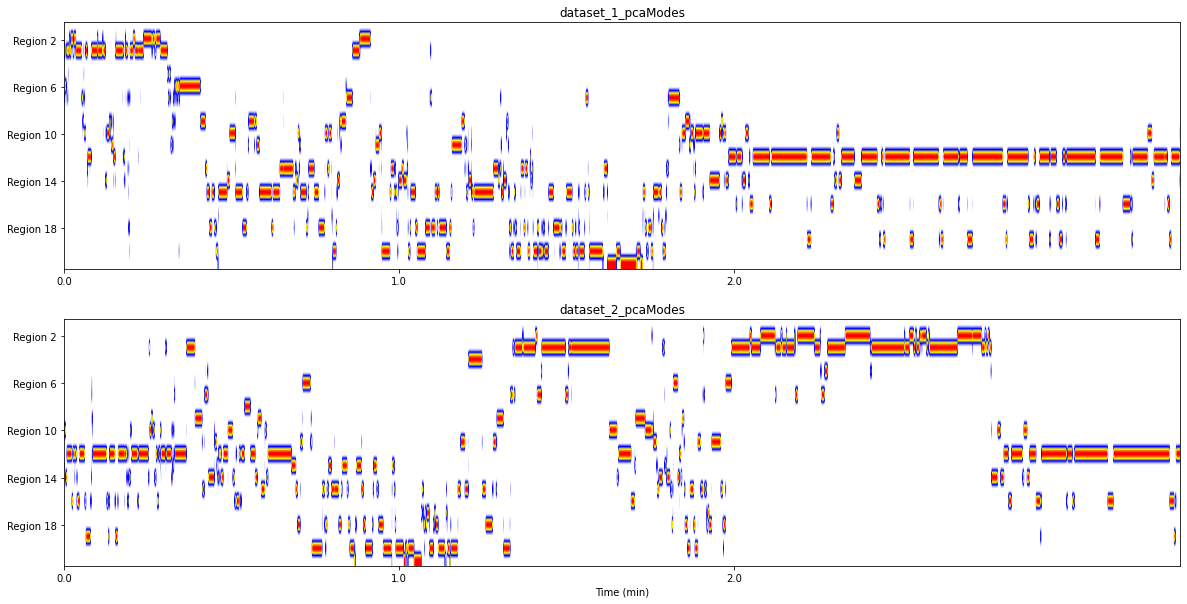

In [26]:
wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))

wregs = wshedfile['watershedRegions'].flatten()
ethogram = np.zeros((wregs.max()+1, len(wregs)))

for wreg in range(1, wregs.max()+1):
  ethogram[wreg, np.where(wregs==wreg)[0]] = 1.0


ethogram = np.split(ethogram.T, np.cumsum(wshedfile['zValLens'][0].flatten())[:-1])

fig, axes = plt.subplots(2, 1, figsize=(20,10))

for e, name, ax in zip(ethogram, wshedfile['zValNames'][0], axes.flatten()):
  print(e.shape)
  ax.imshow(e.T, aspect='auto', cmap=mmpy.gencmap())
  ax.set_title(name[0][0])
  ax.set_yticks([i for i in range(1, wregs.max()+1, 4)])
  ax.set_yticklabels(['Region %i'%(j+1) for j in range(1, wregs.max()+1, 4)])

  xticklocs = [6000*i for i in range(3)]
  ax.set_xticks(xticklocs)
  ax.set_xticklabels([j/(6000) for j in xticklocs])

ax.set_xlabel('Time (min)')

## 5.2 Visualize behavioral map

Run the below code to see the behavioral map in action. This may take **2 minutes** to run.

 99%|█████████▉| 150/151 [00:12<00:00, 11.61it/s]


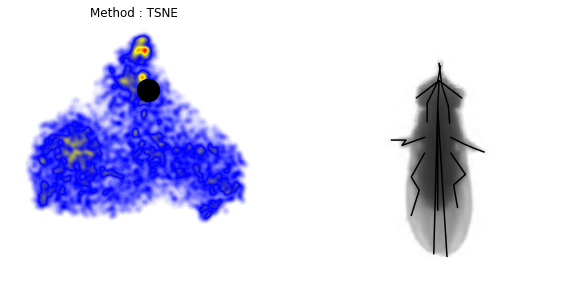

In [27]:
wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))

try:
  tqdm._instances.clear()
except:
  pass

fig, axes = plt.subplots(1, 2, figsize=(10,5))
zValues = wshedfile['zValues']
m = np.abs(zValues).max()


sigma=2.0
_, xx, density = mmpy.findPointDensity(zValues, sigma, 511, [-m-10, m+10])
axes[0].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
axes[0].axis('off')
axes[0].set_title('Method : %s'%parameters.method)
sc = axes[0].scatter([],[],marker='o', color='k', s=500)

h5ind = 1
tstart = 0
connections = [np.arange(6,10), np.arange(10,14), np.arange(14,18), np.arange(18,22), np.arange(22,26), np.arange(26,30),
              [2,0,1],[0,3,4,5], [31,3,30]]

def animate(t):
  t = int(t*clips[h5ind].fps)+tstart
  axes[1].clear()
  im = axes[1].imshow(clips[h5ind].get_frame(t/clips[h5ind].fps), cmap='Greys', origin='lower')
  for conn in connections:
      axes[1].plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], 'k-')
  axes[1].axis('off')
  sc.set_offsets(zValues[20000*h5ind+t])
  return mplfig_to_npimage(fig) #im, ax


anim = VideoClip(animate, duration=10) # will throw memory error for more than 100.
anim.ipython_display(fps=15, loop=True, autoplay=True, maxduration=120)